In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
# 📦 Install packages (if needed in Kaggle notebook, uncomment below lines)
# !pip install timm albumentations opencv-python --quiet
# !pip install -q grad-cam
# !pip install -q seaborn

# ✅ Imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import timm  # for pretrained CNNs
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

# ✅ Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [6]:
# 📦 Install essential packages (only needed once)
# !pip install -q timm albumentations opencv-python
# !pip install -q grad-cam

# ✅ Imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# ✅ Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


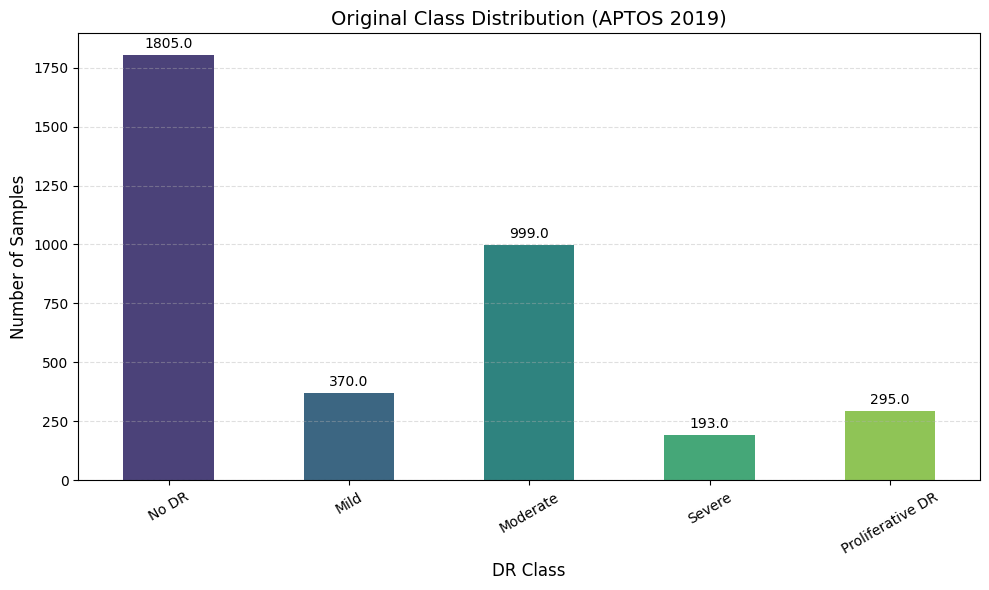

In [7]:
# 📁 Set data paths
DATA_DIR = "/kaggle/input/aptos2019-blindness-detection/"
IMG_DIR = os.path.join(DATA_DIR, "train_images")
PLOT_DIR = "./plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# 🧾 Load CSV and map image paths
df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
df['image_path'] = df['id_code'].apply(lambda x: os.path.join(IMG_DIR, x + '.png'))

# 🔠 Map labels to text for clarity
class_map = {
    0: 'No DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferative DR'
}
df['diagnosis_text'] = df['diagnosis'].map(class_map)

# 📊 Visualize original class distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='diagnosis', palette='viridis', width=0.5)

# Add value labels on top
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height() + 15),
                ha='center', va='bottom', fontsize=10)

# Axis labels and styling
plt.title('Original Class Distribution (APTOS 2019)', fontsize=14)
plt.xlabel('DR Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(ticks=np.arange(5), labels=[class_map[i] for i in range(5)], rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

# 💾 Save plot
plt.savefig(os.path.join('original_class_distribution.png'), dpi=300)
plt.show()


In [8]:
from sklearn.utils import resample

# 📋 Separate DataFrame by class
dfs = [df[df['diagnosis'] == i] for i in range(5)]

# 🔍 Get the max count among all classes
max_count = max([len(d) for d in dfs])

# 🔁 Oversample each class to match max_count
balanced_dfs = [resample(d, replace=True, n_samples=max_count, random_state=42) for d in dfs]

# 📎 Combine and shuffle the balanced dataset
balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

# 💾 Save CSV for reproducibility
SPLIT_DIR = "./splits"
os.makedirs(SPLIT_DIR, exist_ok=True)
balanced_csv_path = os.path.join(SPLIT_DIR, "train_balanced.csv")
balanced_df.to_csv(balanced_csv_path, index=False)

# 📊 Show new class distribution
print("✅ Balanced Class Distribution:")
print(balanced_df['diagnosis'].value_counts().sort_index())

print(f"💾 Saved balanced dataset CSV to: {balanced_csv_path}")


✅ Balanced Class Distribution:
diagnosis
0    1805
1    1805
2    1805
3    1805
4    1805
Name: count, dtype: int64
💾 Saved balanced dataset CSV to: ./splits/train_balanced.csv


In [9]:
# ✅ Define image transforms using Albumentations
def get_transforms(image_size=224):
    train_transform = A.Compose([
        A.Resize(image_size, image_size),
        A.RandomBrightnessContrast(p=0.3),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=0.3),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.3),
        A.CLAHE(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406),  # ImageNet stats
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    return train_transform, val_transform

# ✅ Custom Dataset class
class APTOSDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['image_path']
        label = row['diagnosis']

        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transform
        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label


In [10]:
# 🔁 Load the balanced dataset
balanced_df = pd.read_csv(os.path.join(SPLIT_DIR, "train_balanced.csv"))

# 🧠 Split into train and validation (stratified)
train_df, val_df = train_test_split(
    balanced_df,
    test_size=0.2,
    stratify=balanced_df['diagnosis'],
    random_state=42
)

# 💾 Save splits
train_df.to_csv(os.path.join(SPLIT_DIR, "train_final.csv"), index=False)
val_df.to_csv(os.path.join(SPLIT_DIR, "val_final.csv"), index=False)

print(f"✅ Train samples: {len(train_df)} | Val samples: {len(val_df)}")

# 🌀 Get transforms
train_transform, val_transform = get_transforms(image_size=224)

# 🧳 Create datasets
train_dataset = APTOSDataset(train_df, transform=train_transform)
val_dataset = APTOSDataset(val_df, transform=val_transform)

# 🧱 Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


✅ Train samples: 7220 | Val samples: 1805


In [3]:
class XDRNet(nn.Module):
    def __init__(self, model_name='efficientnet_b0', num_classes=5, pretrained=True):
        super(XDRNet, self).__init__()

        # 🧠 CNN backbone from TIMM
        self.backbone = timm.create_model(model_name, pretrained=pretrained, features_only=True)
        self.out_channels = self.backbone.feature_info[-1]['num_chs']  # usually 1280 for efficientnet_b0

        # 🧱 Attention block
        self.attn_dim = self.out_channels
        self.self_attn = nn.MultiheadAttention(embed_dim=self.attn_dim, num_heads=4, batch_first=True)

        # 🌀 Pooling before attention (reshape required)
        self.pool = nn.AdaptiveAvgPool2d(1)

        # 🧾 Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(self.attn_dim),
            nn.Dropout(0.3),
            nn.Linear(self.attn_dim, num_classes)
        )

    def forward(self, x):
        # Feature extraction from CNN
        features = self.backbone(x)[-1]  # Shape: [B, C, H, W]
        B, C, H, W = features.size()
        tokens = features.view(B, C, -1).permute(0, 2, 1)  # → [B, HW, C]

        # Transformer-style attention
        attn_out, _ = self.self_attn(tokens, tokens, tokens)  # → [B, HW, C]
        attn_pooled = attn_out.mean(dim=1)  # Global token average

        # Classify
        out = self.classifier(attn_pooled)
        return out


In [11]:
# ✅ Initialize the model
model = XDRNet(model_name='efficientnet_b0', num_classes=5).to(device)

# ⚖️ Compute class weights from train_df
class_counts = train_df['diagnosis'].value_counts().sort_index().values
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float32)
class_weights = class_weights / class_weights.sum()  # normalize
class_weights = class_weights.to(device)

# ✅ Define loss function with weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ✅ Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# 🔁 Learning Rate Scheduler (Cosine Annealing)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# ⚡ AMP support
scaler = torch.cuda.amp.GradScaler()

# 📁 Model save directory
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)


In [12]:
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss = 0
    all_preds, all_labels = [], []

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return epoch_loss, acc, f1


def validate_one_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return epoch_loss, acc, f1


In [13]:
# 📈 Track best F1
best_f1 = 0.0
NUM_EPOCHS = 20

# 📊 Store metrics
train_metrics = {'loss': [], 'acc': [], 'f1': []}
val_metrics = {'loss': [], 'acc': [], 'f1': []}

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n🔁 Epoch {epoch}/{NUM_EPOCHS}")
    print("-" * 30)

    # 🔄 Train
    train_loss, train_acc, train_f1 = train_one_epoch(
        model, train_loader, optimizer, criterion, scaler)

    # 🔍 Validate
    val_loss, val_acc, val_f1 = validate_one_epoch(
        model, val_loader, criterion)

    # 🔁 Scheduler step
    scheduler.step()

    # 📢 Print epoch summary
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    # 💾 Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_path = os.path.join(MODEL_DIR, "xdrnet_best.pth")
        torch.save(model.state_dict(), best_path)
        print(f"✅ Best model saved with F1: {best_f1:.4f}")

    # 📊 Log metrics
    train_metrics['loss'].append(train_loss)
    train_metrics['acc'].append(train_acc)
    train_metrics['f1'].append(train_f1)

    val_metrics['loss'].append(val_loss)
    val_metrics['acc'].append(val_acc)
    val_metrics['f1'].append(val_f1)



🔁 Epoch 1/20
------------------------------


Train Loss: 0.9673 | Acc: 0.6125 | F1: 0.6049
Val   Loss: 0.5082 | Acc: 0.8255 | F1: 0.8239
✅ Best model saved with F1: 0.8239

🔁 Epoch 2/20
------------------------------


Train Loss: 0.5329 | Acc: 0.7953 | F1: 0.7935
Val   Loss: 0.2877 | Acc: 0.9097 | F1: 0.9080
✅ Best model saved with F1: 0.9080

🔁 Epoch 3/20
------------------------------


Train Loss: 0.3287 | Acc: 0.8814 | F1: 0.8809
Val   Loss: 0.1762 | Acc: 0.9557 | F1: 0.9552
✅ Best model saved with F1: 0.9552

🔁 Epoch 4/20
------------------------------


Train Loss: 0.2297 | Acc: 0.9201 | F1: 0.9200
Val   Loss: 0.1610 | Acc: 0.9562 | F1: 0.9559
✅ Best model saved with F1: 0.9559

🔁 Epoch 5/20
------------------------------


Train Loss: 0.1726 | Acc: 0.9421 | F1: 0.9420
Val   Loss: 0.1290 | Acc: 0.9618 | F1: 0.9614
✅ Best model saved with F1: 0.9614

🔁 Epoch 6/20
------------------------------


Train Loss: 0.1333 | Acc: 0.9539 | F1: 0.9539
Val   Loss: 0.1270 | Acc: 0.9662 | F1: 0.9659
✅ Best model saved with F1: 0.9659

🔁 Epoch 7/20
------------------------------


Train Loss: 0.1093 | Acc: 0.9650 | F1: 0.9650
Val   Loss: 0.1121 | Acc: 0.9684 | F1: 0.9681
✅ Best model saved with F1: 0.9681

🔁 Epoch 8/20
------------------------------


Train Loss: 0.0914 | Acc: 0.9705 | F1: 0.9705
Val   Loss: 0.1071 | Acc: 0.9684 | F1: 0.9682
✅ Best model saved with F1: 0.9682

🔁 Epoch 9/20
------------------------------


Train Loss: 0.0868 | Acc: 0.9702 | F1: 0.9702
Val   Loss: 0.1038 | Acc: 0.9723 | F1: 0.9720
✅ Best model saved with F1: 0.9720

🔁 Epoch 10/20
------------------------------


Train Loss: 0.0828 | Acc: 0.9713 | F1: 0.9713
Val   Loss: 0.1026 | Acc: 0.9729 | F1: 0.9726
✅ Best model saved with F1: 0.9726

🔁 Epoch 11/20
------------------------------


Train Loss: 0.0833 | Acc: 0.9715 | F1: 0.9714
Val   Loss: 0.1059 | Acc: 0.9729 | F1: 0.9726
✅ Best model saved with F1: 0.9726

🔁 Epoch 12/20
------------------------------


Train Loss: 0.0789 | Acc: 0.9733 | F1: 0.9732
Val   Loss: 0.1071 | Acc: 0.9729 | F1: 0.9726

🔁 Epoch 13/20
------------------------------


Train Loss: 0.0816 | Acc: 0.9720 | F1: 0.9720
Val   Loss: 0.1035 | Acc: 0.9723 | F1: 0.9720

🔁 Epoch 14/20
------------------------------


Train Loss: 0.0802 | Acc: 0.9734 | F1: 0.9734
Val   Loss: 0.1012 | Acc: 0.9729 | F1: 0.9726
✅ Best model saved with F1: 0.9726

🔁 Epoch 15/20
------------------------------


Train Loss: 0.0859 | Acc: 0.9698 | F1: 0.9698
Val   Loss: 0.1018 | Acc: 0.9734 | F1: 0.9732
✅ Best model saved with F1: 0.9732

🔁 Epoch 16/20
------------------------------


Train Loss: 0.0858 | Acc: 0.9717 | F1: 0.9717
Val   Loss: 0.1158 | Acc: 0.9673 | F1: 0.9671

🔁 Epoch 17/20
------------------------------


Train Loss: 0.0960 | Acc: 0.9659 | F1: 0.9659
Val   Loss: 0.1235 | Acc: 0.9723 | F1: 0.9720

🔁 Epoch 18/20
------------------------------


Train Loss: 0.0944 | Acc: 0.9691 | F1: 0.9691
Val   Loss: 0.1042 | Acc: 0.9729 | F1: 0.9727

🔁 Epoch 19/20
------------------------------


Train Loss: 0.0979 | Acc: 0.9680 | F1: 0.9680
Val   Loss: 0.1129 | Acc: 0.9740 | F1: 0.9738
✅ Best model saved with F1: 0.9738

🔁 Epoch 20/20
------------------------------


Train Loss: 0.0904 | Acc: 0.9701 | F1: 0.9701
Val   Loss: 0.1283 | Acc: 0.9662 | F1: 0.9660


In [23]:
def plot_training_curves(train_metrics, val_metrics, save_dir="./plots"):
    os.makedirs(save_dir, exist_ok=True)
    epochs = range(1, len(train_metrics['loss']) + 1)

    # 📉 Plot Loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['loss'], label='Train Loss')
    plt.plot(epochs, val_metrics['loss'], label='Val Loss')
    plt.title("Loss Curve", fontweight="bold")
    plt.xlabel("Epoch", fontweight="bold")
    plt.ylabel("Loss", fontweight="bold")
    plt.xticks(fontweight="bold")
    plt.yticks(fontweight="bold")
    plt.legend(prop={"weight": "bold"})
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "loss_curve.png"), dpi=300)
    plt.show()

    # 📈 Plot Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['acc'], label='Train Accuracy')
    plt.plot(epochs, val_metrics['acc'], label='Val Accuracy')
    plt.title("Accuracy Curve", fontweight="bold")
    plt.xlabel("Epoch", fontweight="bold")
    plt.ylabel("Accuracy", fontweight="bold")
    plt.xticks(fontweight="bold")
    plt.yticks(fontweight="bold")
    plt.legend(prop={"weight": "bold"})
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "accuracy_curve.png"), dpi=300)
    plt.show()

    # 📊 Plot F1 Score
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['f1'], label='Train F1 Score')
    plt.plot(epochs, val_metrics['f1'], label='Val F1 Score')
    plt.title("F1 Score Curve", fontweight="bold")
    plt.xlabel("Epoch", fontweight="bold")
    plt.ylabel("F1 Score", fontweight="bold")
    plt.xticks(fontweight="bold")
    plt.yticks(fontweight="bold")
    plt.legend(prop={"weight": "bold"})
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "f1_curve.png"), dpi=300)
    plt.show()


In [25]:
def plot_training_curves(train_metrics, val_metrics, save_dir="./plots"):
    os.makedirs(save_dir, exist_ok=True)
    epochs = range(1, len(train_metrics['loss']) + 1)

    # Common font settings
    title_cfg = {"fontsize": 16, "fontweight": "bold"}
    label_cfg = {"fontsize": 14, "fontweight": "bold"}
    tick_cfg = {"fontsize": 12, "fontweight": "bold"}
    legend_cfg = {"weight": "bold", "size": 12}

    # 📉 Plot Loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['loss'], label='Train Loss')
    plt.plot(epochs, val_metrics['loss'], label='Val Loss')
    plt.title("Loss Curve", **title_cfg)
    plt.xlabel("Epoch", **label_cfg)
    plt.ylabel("Loss", **label_cfg)
    plt.xticks(**tick_cfg)
    plt.yticks(**tick_cfg)
    plt.legend(prop=legend_cfg)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "loss_curve.png"), dpi=300)
    plt.show()

    # 📈 Plot Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['acc'], label='Train Accuracy')
    plt.plot(epochs, val_metrics['acc'], label='Val Accuracy')
    plt.title("Accuracy Curve", **title_cfg)
    plt.xlabel("Epoch", **label_cfg)
    plt.ylabel("Accuracy", **label_cfg)
    plt.xticks(**tick_cfg)
    plt.yticks(**tick_cfg)
    plt.legend(prop=legend_cfg)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "accuracy_curve.png"), dpi=300)
    plt.show()

    # 📊 Plot F1 Score
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['f1'], label='Train F1 Score')
    plt.plot(epochs, val_metrics['f1'], label='Val F1 Score')
    plt.title("F1 Score Curve", **title_cfg)
    plt.xlabel("Epoch", **label_cfg)
    plt.ylabel("F1 Score", **label_cfg)
    plt.xticks(**tick_cfg)
    plt.yticks(**tick_cfg)
    plt.legend(prop=legend_cfg)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "f1_curve.png"), dpi=300)
    plt.show()


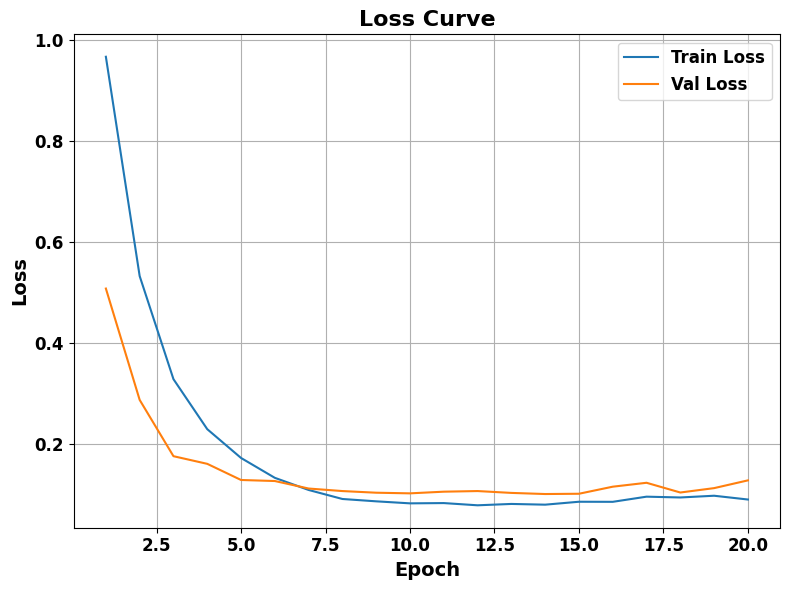

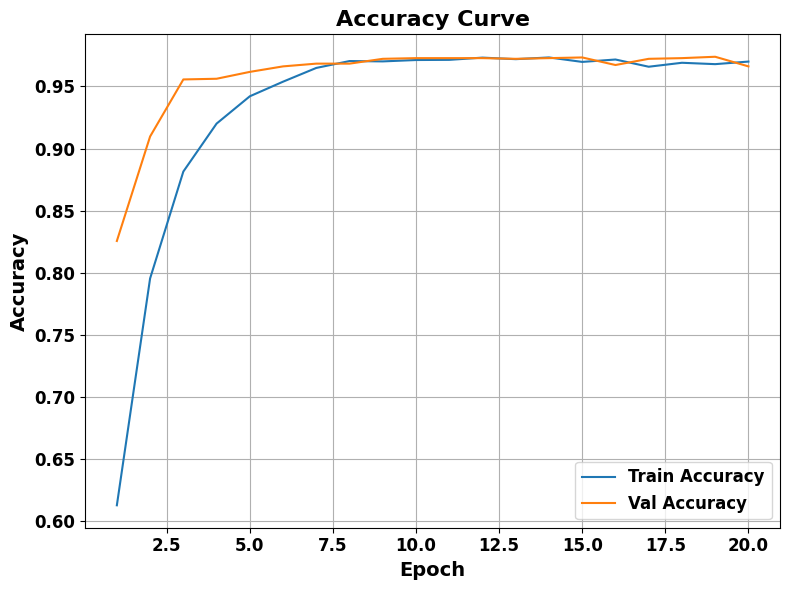

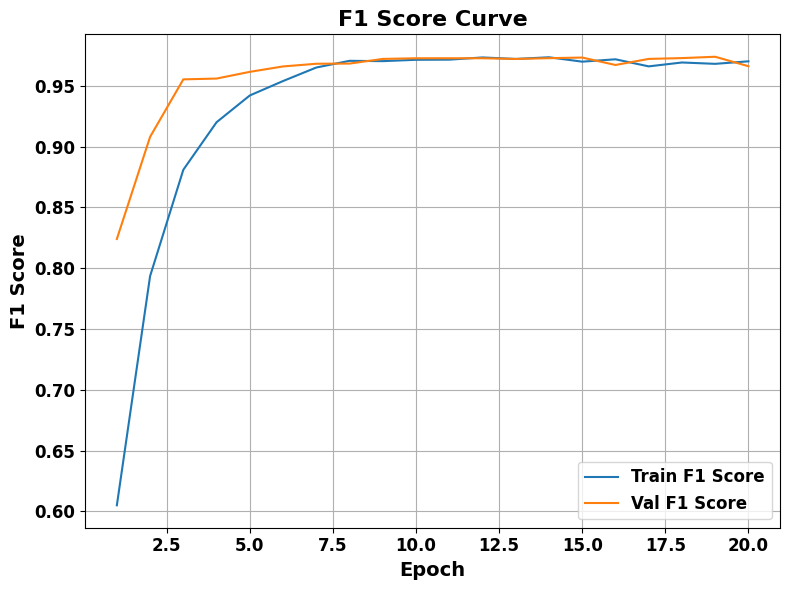

In [26]:
# ✅ Call after training completes
plot_training_curves(train_metrics, val_metrics)

📋 Classification Report:

                  precision    recall  f1-score   support

           No DR     0.9890    0.9945    0.9917       361
            Mild     0.9672    0.9806    0.9739       361
        Moderate     0.9852    0.9197    0.9513       361
          Severe     0.9496    0.9917    0.9702       361
Proliferative DR     0.9807    0.9834    0.9820       361

        accuracy                         0.9740      1805
       macro avg     0.9743    0.9740    0.9738      1805
    weighted avg     0.9743    0.9740    0.9738      1805



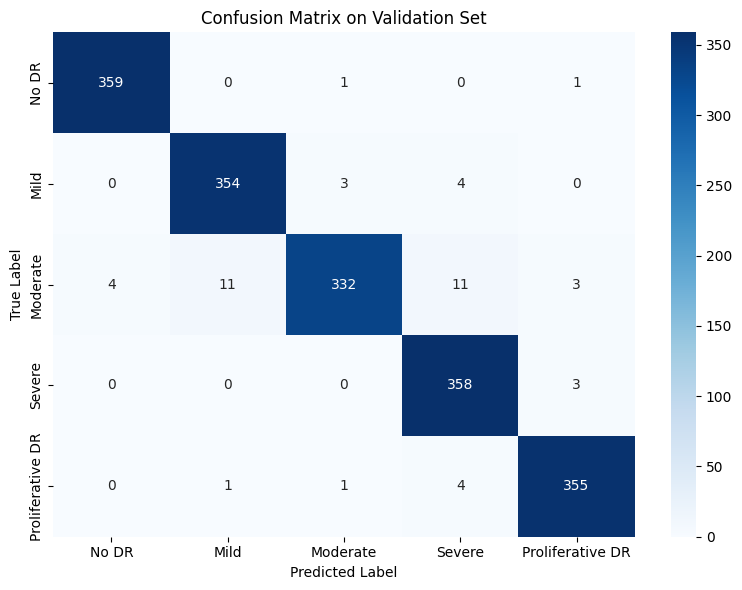

In [27]:
# ✅ Load best model
best_model_path = os.path.join(MODEL_DIR, "xdrnet_best.pth")
model.load_state_dict(torch.load(best_model_path))
model.eval()

# 🔍 Collect predictions on validation set
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating", leave=False):
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# 📊 Confusion Matrix
conf_mat = confusion_matrix(all_labels, all_preds)
class_names = [class_map[i] for i in range(5)]

# 🔍 Classification Report
from sklearn.metrics import classification_report
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# 📉 Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix on Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

# 💾 Save
plt.savefig(os.path.join(PLOT_DIR, "confusion_matrix.png"), dpi=300)
plt.show()


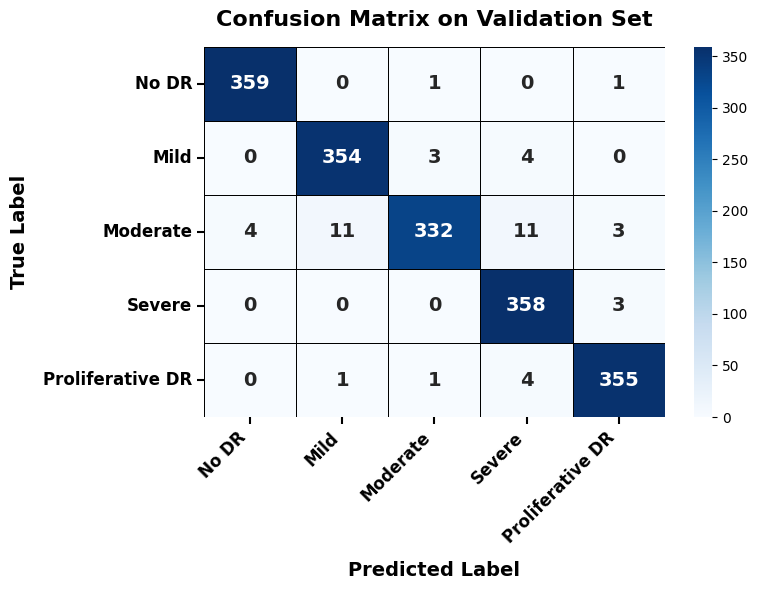

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 📉 Confusion Matrix Heatmap (Bold + Attractive)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True,
    linewidths=0.5,
    linecolor='black',
    annot_kws={"size": 14, "weight": "bold"}  # 🔥 Bigger & bold numbers
)

# ✅ Make axis labels & ticks bold
ax.set_title("Confusion Matrix on Validation Set", fontsize=16, fontweight="bold", pad=15)
ax.set_xlabel("Predicted Label", fontsize=14, fontweight="bold", labelpad=10)
ax.set_ylabel("True Label", fontsize=14, fontweight="bold", labelpad=10)
ax.set_xticklabels(class_names, fontsize=12, fontweight="bold", rotation=45, ha="right")
ax.set_yticklabels(class_names, fontsize=12, fontweight="bold", rotation=0)

# ✅ Thicker tick marks
ax.tick_params(axis="both", which="both", length=5, width=1.5)

# 💾 Save high-quality figure
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "confusion_matrix.png"), dpi=400, bbox_inches="tight")
plt.show()


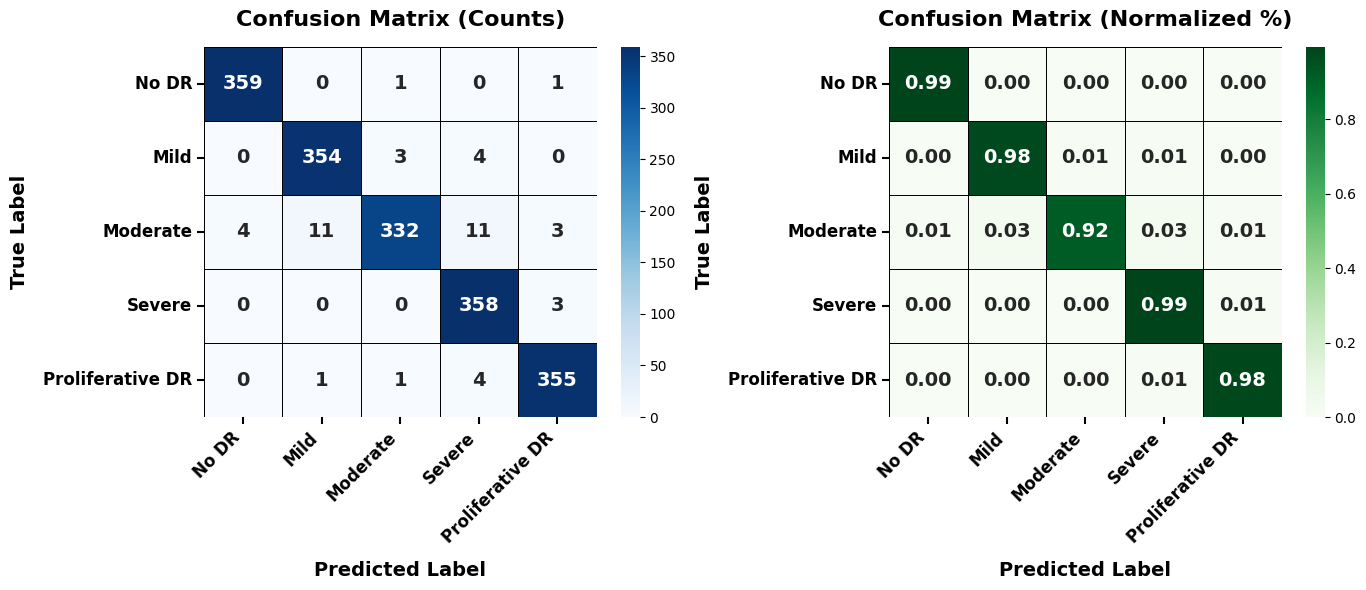

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 📊 Normalized confusion matrix
conf_mat_norm = conf_mat.astype("float") / conf_mat.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# === Left: Counts ===
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True,
    linewidths=0.5,
    linecolor='black',
    annot_kws={"size": 14, "weight": "bold"},
    ax=axes[0]
)
axes[0].set_title("Confusion Matrix (Counts)", fontsize=16, fontweight="bold", pad=15)
axes[0].set_xlabel("Predicted Label", fontsize=14, fontweight="bold", labelpad=10)
axes[0].set_ylabel("True Label", fontsize=14, fontweight="bold", labelpad=10)
axes[0].set_xticklabels(class_names, fontsize=12, fontweight="bold", rotation=45, ha="right")
axes[0].set_yticklabels(class_names, fontsize=12, fontweight="bold", rotation=0)
axes[0].tick_params(axis="both", which="both", length=5, width=1.5)

# === Right: Normalized (%) ===
sns.heatmap(
    conf_mat_norm,
    annot=True,
    fmt=".2f",
    cmap='Greens',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True,
    linewidths=0.5,
    linecolor='black',
    annot_kws={"size": 14, "weight": "bold"},
    ax=axes[1]
)
axes[1].set_title("Confusion Matrix (Normalized %)", fontsize=16, fontweight="bold", pad=15)
axes[1].set_xlabel("Predicted Label", fontsize=14, fontweight="bold", labelpad=10)
axes[1].set_ylabel("True Label", fontsize=14, fontweight="bold", labelpad=10)
axes[1].set_xticklabels(class_names, fontsize=12, fontweight="bold", rotation=45, ha="right")
axes[1].set_yticklabels(class_names, fontsize=12, fontweight="bold", rotation=0)
axes[1].tick_params(axis="both", which="both", length=5, width=1.5)

# 💾 Save side-by-side figure
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "confusion_matrix_counts_vs_normalized.png"),
            dpi=400, bbox_inches="tight")
plt.show()


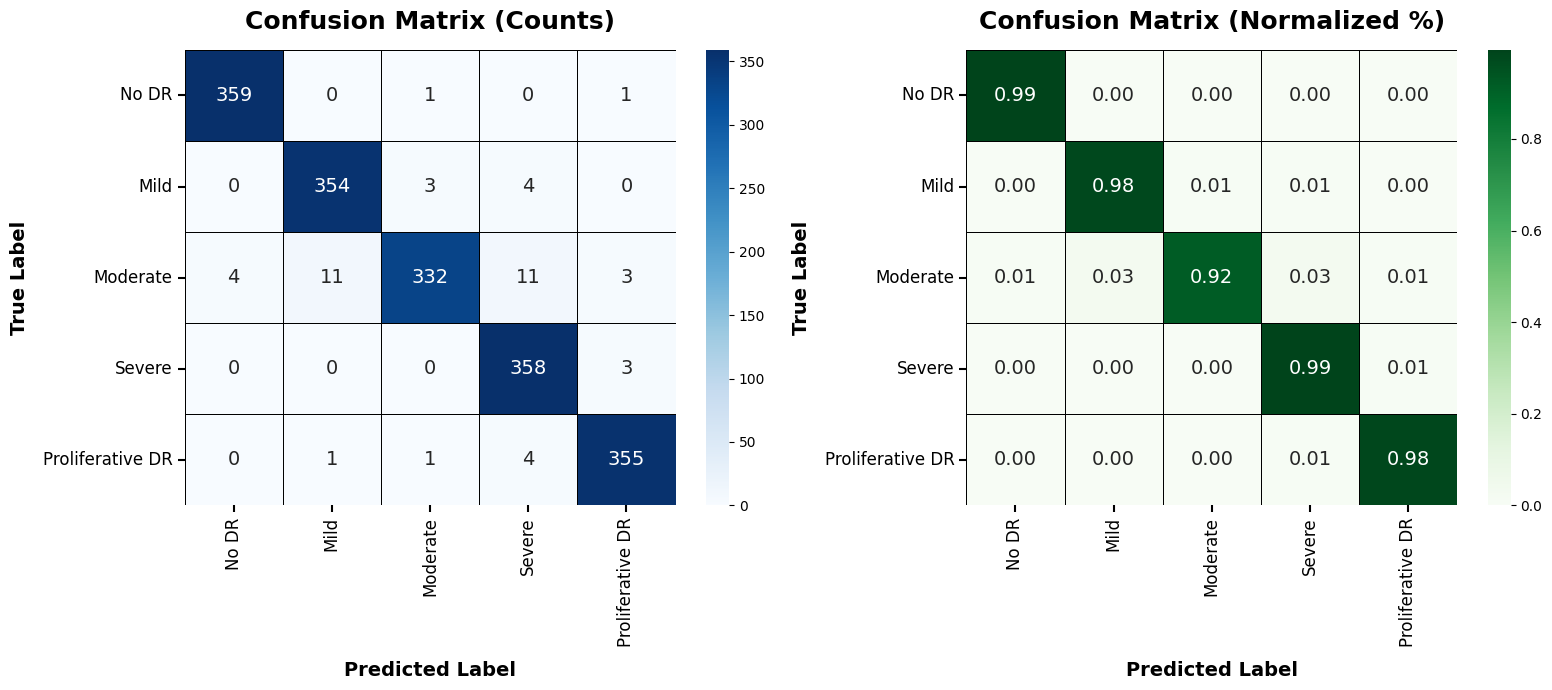

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 📊 Normalized confusion matrix
conf_mat_norm = conf_mat.astype("float") / conf_mat.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))  # bigger figure

# === Left: Counts ===
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True,
    linewidths=0.5,
    linecolor='black',
    annot_kws={"size": 14},  # 🔹 removed bold, fontsize=14
    ax=axes[0]
)
axes[0].set_title("Confusion Matrix (Counts)", fontsize=18, fontweight="bold", pad=15)
axes[0].set_xlabel("Predicted Label", fontsize=14, fontweight="bold", labelpad=10)
axes[0].set_ylabel("True Label", fontsize=14, fontweight="bold", labelpad=10)
axes[0].set_xticklabels(class_names, fontsize=12, rotation=90)  # 🔹 90° rotation
axes[0].set_yticklabels(class_names, fontsize=12, rotation=0)
axes[0].tick_params(axis="both", which="both", length=5, width=1.5)

# === Right: Normalized (%) ===
sns.heatmap(
    conf_mat_norm,
    annot=True,
    fmt=".2f",
    cmap='Greens',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True,
    linewidths=0.5,
    linecolor='black',
    annot_kws={"size": 14},  # 🔹 removed bold, fontsize=14
    ax=axes[1]
)
axes[1].set_title("Confusion Matrix (Normalized %)", fontsize=18, fontweight="bold", pad=15)
axes[1].set_xlabel("Predicted Label", fontsize=14, fontweight="bold", labelpad=10)
axes[1].set_ylabel("True Label", fontsize=14, fontweight="bold", labelpad=10)
axes[1].set_xticklabels(class_names, fontsize=12, rotation=90)  # 🔹 90° rotation
axes[1].set_yticklabels(class_names, fontsize=12, rotation=0)
axes[1].tick_params(axis="both", which="both", length=5, width=1.5)

# 💾 Save side-by-side figure
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "confusion_matrix_counts_vs_normalized.png"),
            dpi=400, bbox_inches="tight")
plt.show()


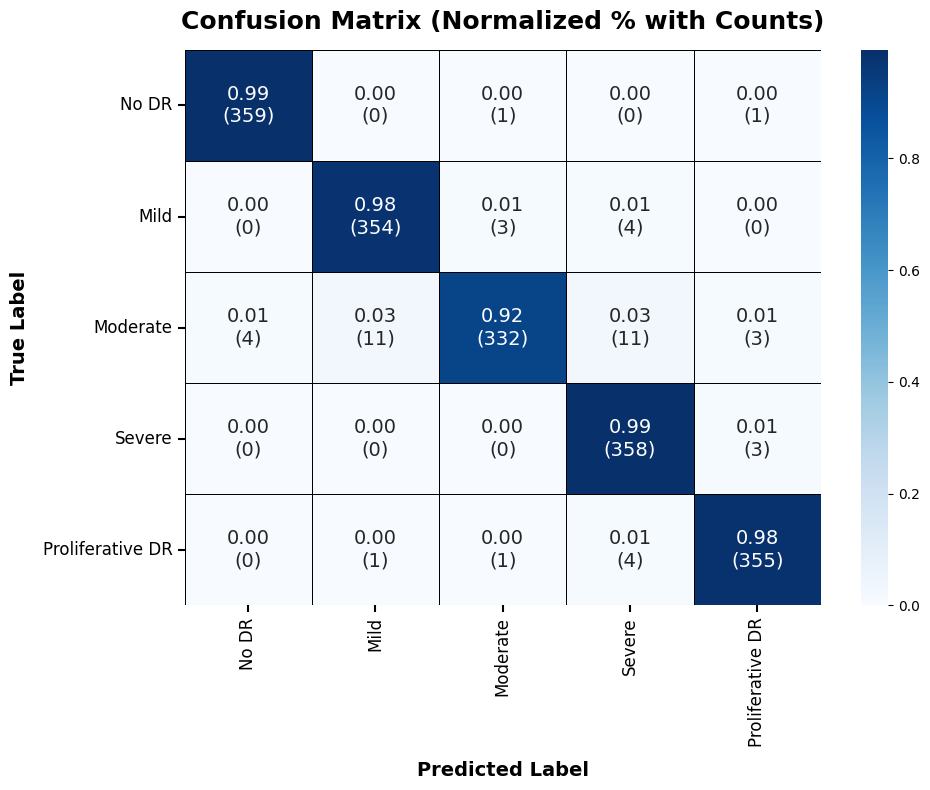

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 📊 Normalized confusion matrix
conf_mat_norm = conf_mat.astype("float") / conf_mat.sum(axis=1)[:, np.newaxis]

# 🔹 Create combined annotation: percentage + raw count
annot = np.empty_like(conf_mat).astype(str)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        annot[i, j] = f"{conf_mat_norm[i, j]:.2f}\n({conf_mat[i, j]})"

plt.figure(figsize=(10, 8))  # Bigger plot for clarity
ax = sns.heatmap(
    conf_mat_norm,              # use normalized values for color scaling
    annot=annot,                # combined text
    fmt="",                     # already formatted
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True,
    linewidths=0.5,
    linecolor="black",
    annot_kws={"size": 14}      # 🔹 clean numbers (no bold), size=14
)

# ✅ Titles and axis labels
ax.set_title("Confusion Matrix (Normalized % with Counts)", fontsize=18, fontweight="bold", pad=15)
ax.set_xlabel("Predicted Label", fontsize=14, fontweight="bold", labelpad=10)
ax.set_ylabel("True Label", fontsize=14, fontweight="bold", labelpad=10)

# ✅ Tick labels for clear visibility
ax.set_xticklabels(class_names, fontsize=12, rotation=90)  # vertical labels
ax.set_yticklabels(class_names, fontsize=12, rotation=0)

ax.tick_params(axis="both", which="both", length=5, width=1.5)

# 💾 Save high-quality figure
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "confusion_matrix_combined.png"), dpi=400, bbox_inches="tight")
plt.show()


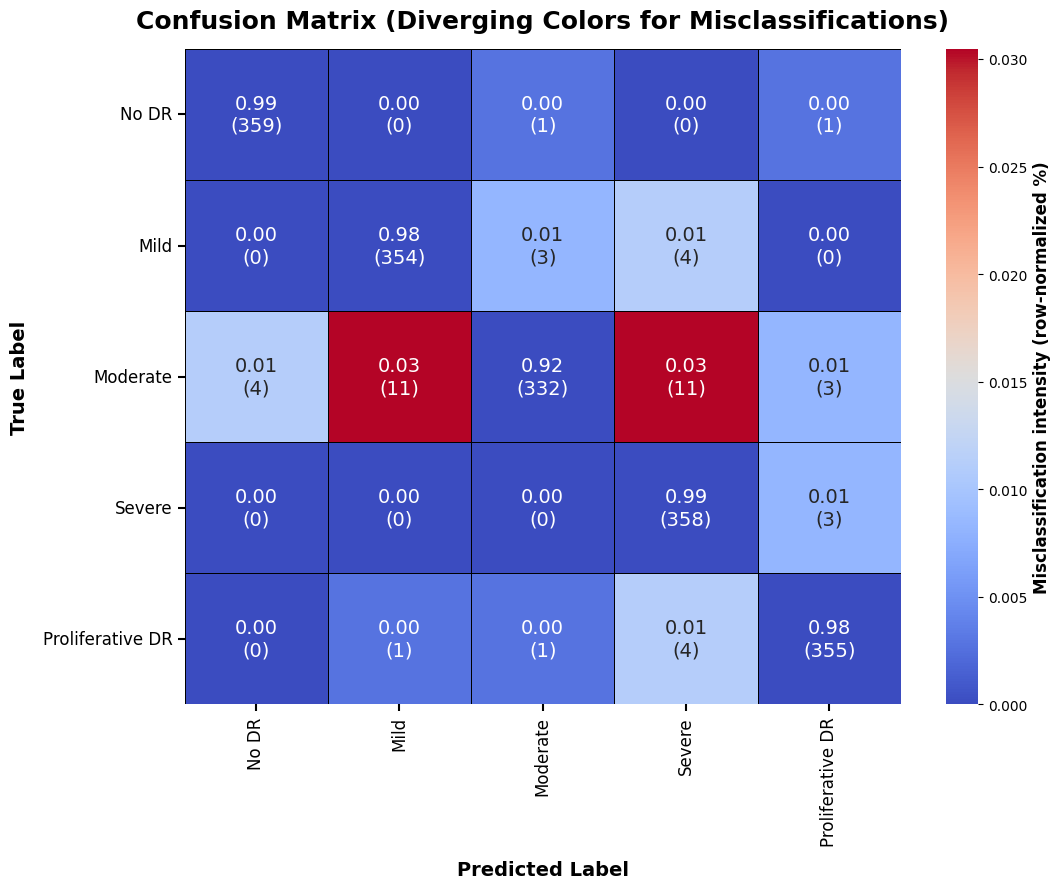

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1) Row-normalized matrix for percentages
conf_mat = np.asarray(conf_mat, dtype=float)
row_sums = conf_mat.sum(axis=1, keepdims=True).clip(min=1.0)  # avoid /0
conf_norm = conf_mat / row_sums

# 2) Build combined annotation: "0.87\n(123)"
annot = np.empty_like(conf_mat, dtype=object)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        annot[i, j] = f"{conf_norm[i, j]:.2f}\n({int(conf_mat[i, j])})"

# 3) Color values: emphasize off-diagonals (misclassifications)
#    Put diagonal near 0 so it stays cool; off-diagonals reflect their normalized %.
color_vals = conf_norm.copy()
np.fill_diagonal(color_vals, 0.0)

# 4) Plot
plt.figure(figsize=(11, 9))  # larger figure
ax = sns.heatmap(
    color_vals,                 # drives the colors (diagonal cooled)
    annot=annot,                # shows real % + counts
    fmt="",
    cmap="coolwarm",            # diverging colormap
    vmin=0.0,
    vmax=(color_vals[~np.eye(color_vals.shape[0], dtype=bool)].max() if color_vals.size > 1 else 1.0),
    center=None,                # center not needed since we start at 0
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True,
    linewidths=0.6,
    linecolor="black",
    annot_kws={"size": 14}      # clean (no bold), size 14
)

# Titles & axes (bold); x-labels vertical for clarity
ax.set_title("Confusion Matrix (Diverging Colors for Misclassifications)", fontsize=18, fontweight="bold", pad=15)
ax.set_xlabel("Predicted Label", fontsize=14, fontweight="bold", labelpad=10)
ax.set_ylabel("True Label", fontsize=14, fontweight="bold", labelpad=10)
ax.set_xticklabels(class_names, fontsize=12, rotation=90)
ax.set_yticklabels(class_names, fontsize=12, rotation=0)
ax.tick_params(axis="both", which="both", length=5, width=1.5)

# Colorbar label
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel("Misclassification intensity (row-normalized %)", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "confusion_matrix_diverging_combined.png"), dpi=400, bbox_inches="tight")
plt.show()


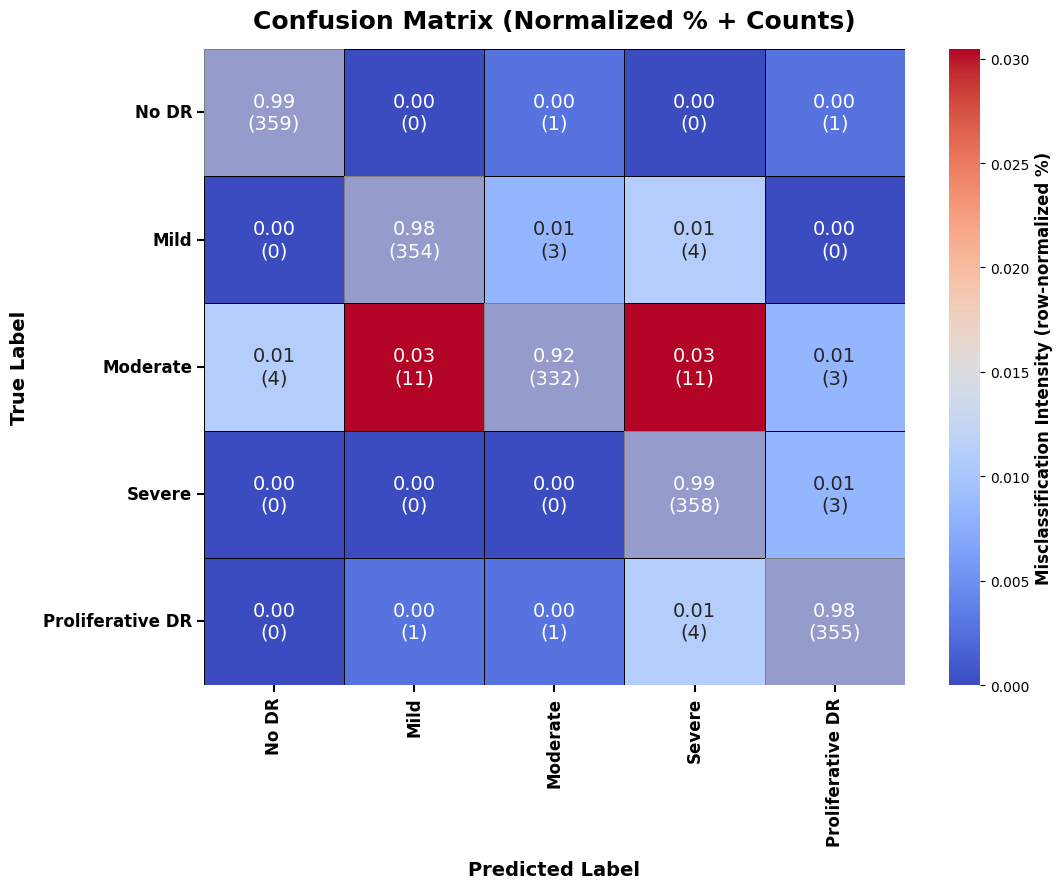

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1) Row-normalized matrix for percentages
conf_mat = np.asarray(conf_mat, dtype=float)
row_sums = conf_mat.sum(axis=1, keepdims=True).clip(min=1.0)
conf_norm = conf_mat / row_sums

# 2) Combined annotation: % + counts
annot = np.empty_like(conf_mat, dtype=object)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        annot[i, j] = f"{conf_norm[i, j]:.2f}\n({int(conf_mat[i, j])})"

# 3) Off-diagonal values drive colors
color_vals = conf_norm.copy()
np.fill_diagonal(color_vals, 0.0)  # diagonal will be overlaid gray later

# 4) Plot
plt.figure(figsize=(11, 9))
ax = sns.heatmap(
    color_vals,
    annot=annot,
    fmt="",
    cmap="coolwarm",
    vmin=0.0,
    vmax=(color_vals[~np.eye(color_vals.shape[0], dtype=bool)].max() if color_vals.size > 1 else 1.0),
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True,
    linewidths=0.6,
    linecolor="black",
    annot_kws={"size": 14}   # clean numbers
)

# 5) Overlay gray diagonal boxes
for i in range(conf_mat.shape[0]):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color="lightgray", alpha=0.6, lw=0))

# ✅ Titles & axes
ax.set_title("Confusion Matrix (Normalized % + Counts)", fontsize=18, fontweight="bold", pad=15)
ax.set_xlabel("Predicted Label", fontsize=14, fontweight="bold", labelpad=10)
ax.set_ylabel("True Label", fontsize=14, fontweight="bold", labelpad=10)

# ✅ Bold class names
ax.set_xticklabels(class_names, fontsize=12, fontweight="bold", rotation=90)
ax.set_yticklabels(class_names, fontsize=12, fontweight="bold", rotation=0)

# ✅ Tick marks bold
ax.tick_params(axis="both", which="both", length=5, width=1.5)

# ✅ Colorbar label
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel("Misclassification Intensity (row-normalized %)", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "confusion_matrix_diverging_graydiag.png"), dpi=400, bbox_inches="tight")
plt.show()


In [40]:
!pip install -q git+https://github.com/jacobgil/pytorch-grad-cam.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76

In [46]:
import cv2
from torchvision.utils import make_grid
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# ✅ Select final conv layer from EfficientNet backbone
# ✅ Use the last Conv layer of EfficientNet backbone
target_layer = list(model.backbone.children())[2][6][0]  # Final InvertedResidual block

 # Last feature map layer

# 🎯 Setup Grad-CAM
cam = GradCAM(model=model, target_layers=[target_layer])



# 🔍 Select 3 samples per class from validation set
samples_per_class = 3
samples_dict = {label: [] for label in range(5)}

for image, label in val_dataset:
    if len(samples_dict[label]) < samples_per_class:
        samples_dict[label].append((image, label))
    if all(len(v) == samples_per_class for v in samples_dict.values()):
        break

# 📁 Create directory for Grad-CAM outputs
gradcam_dir = "./plots/gradcam"
os.makedirs(gradcam_dir, exist_ok=True)

# 🔥 Generate Grad-CAMs and save
for class_label, samples in samples_dict.items():
    for idx, (image, label) in enumerate(samples):
        input_tensor = image.unsqueeze(0).to(device)
        input_numpy = image.permute(1, 2, 0).numpy()
        input_normalized = (input_numpy - input_numpy.min()) / (input_numpy.max() - input_numpy.min())

        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(label)])
        grayscale_cam = grayscale_cam[0]
        cam_image = show_cam_on_image(input_normalized, grayscale_cam, use_rgb=True)

        # 📷 Save Grad-CAM
        fname = f"class{class_label}_sample{idx + 1}.png"
        cv2.imwrite(os.path.join(gradcam_dir, fname), cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR))

print("✅ Grad-CAM visualizations saved to:", gradcam_dir)


✅ Grad-CAM visualizations saved to: ./plots/gradcam


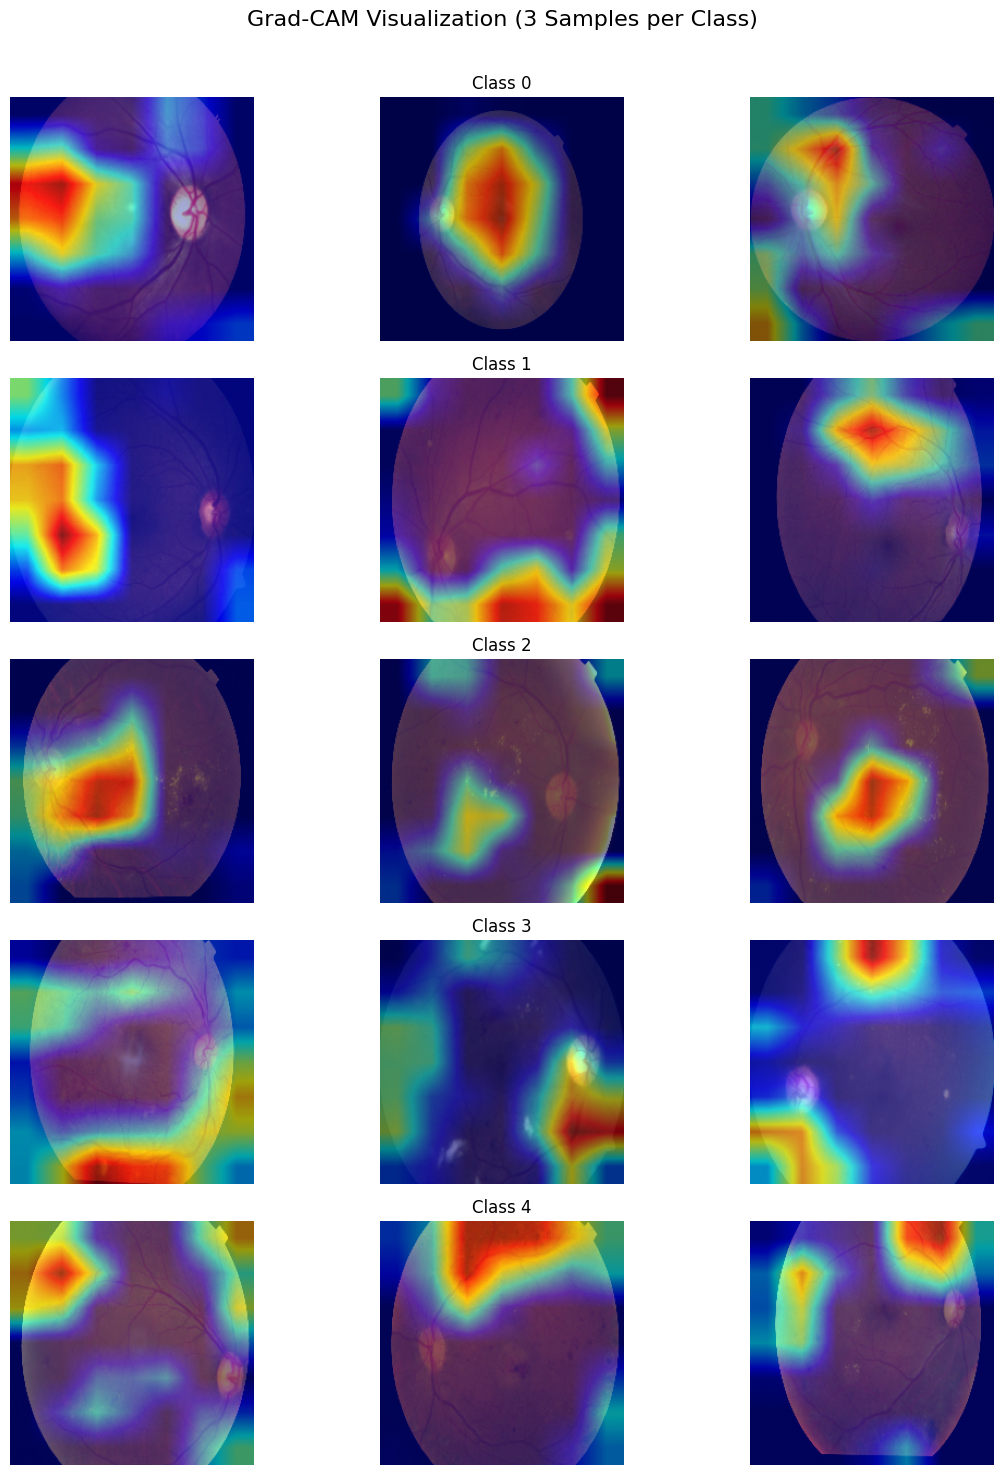

In [48]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# 📁 Path where Grad-CAM images are stored
gradcam_dir = "/kaggle/working/plots/gradcam"

# 📂 Get image files sorted
image_files = sorted([f for f in os.listdir(gradcam_dir) if f.endswith(".png")])

# 🧠 Expected format: "gradcam_classX_index.png"
# Group images by class
from collections import defaultdict
class_images = defaultdict(list)
for f in image_files:
    if "class" in f:
        cls = f.split("class")[1].split("_")[0]
        class_images[cls].append(f)

# 📊 Plotting in grid 5 rows (one per class), 3 columns (3 grad-CAM images per class)
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(12, 15))
fig.suptitle("Grad-CAM Visualization (3 Samples per Class)", fontsize=16)

for row, cls in enumerate(sorted(class_images.keys())):
    for col in range(3):
        ax = axs[row, col]
        try:
            img_path = os.path.join(gradcam_dir, class_images[cls][col])
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis("off")
            if col == 1:
                ax.set_title(f"Class {cls}", fontsize=12)
        except IndexError:
            ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("/kaggle/working/gradcam_classwise_grid.png")
plt.show()


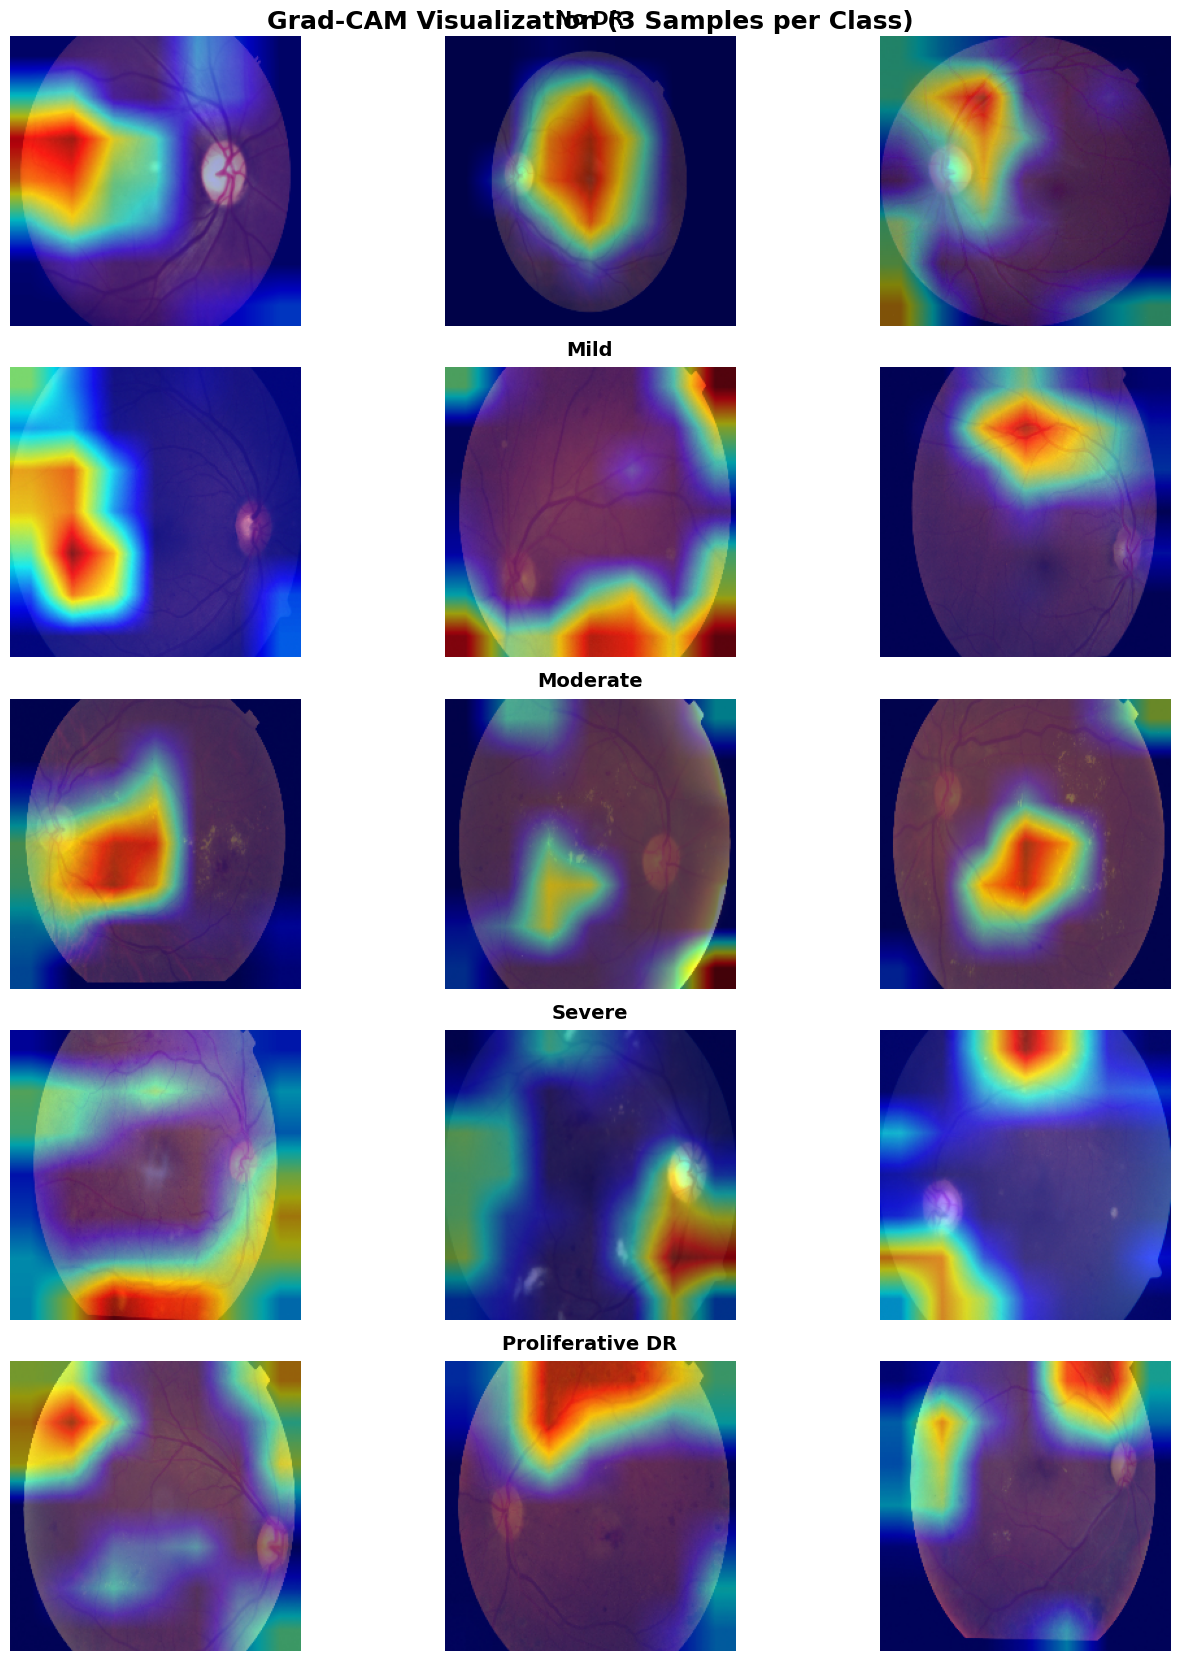

In [49]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict

# 📁 Path where Grad-CAM images are stored
gradcam_dir = "/kaggle/working/plots/gradcam"

# 📂 Get image files sorted
image_files = sorted([f for f in os.listdir(gradcam_dir) if f.endswith(".png")])

# 🧠 Expected format: "gradcam_classX_index.png"
# Group images by class
class_images = defaultdict(list)
for f in image_files:
    if "class" in f:
        cls = f.split("class")[1].split("_")[0]
        class_images[cls].append(f)

# 🔖 Mapping from class index → real name
class_map = {
    "0": "No DR",
    "1": "Mild",
    "2": "Moderate",
    "3": "Severe",
    "4": "Proliferative DR"
}

# 📊 Plotting in grid: 5 rows (one per class), 3 columns
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(14, 18))
fig.suptitle("Grad-CAM Visualization (3 Samples per Class)", fontsize=18, fontweight="bold", y=0.92)

for row, cls in enumerate(sorted(class_images.keys(), key=int)):
    for col in range(3):
        ax = axs[row, col]
        try:
            img_path = os.path.join(gradcam_dir, class_images[cls][col])
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis("off")

            # 🏷️ Add row title only in the middle column
            if col == 1:
                ax.set_title(class_map.get(cls, f"Class {cls}"),
                             fontsize=14, fontweight="bold", pad=8)
        except IndexError:
            ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("/kaggle/working/gradcam_classwise_grid.png", dpi=300, bbox_inches="tight")
plt.show()


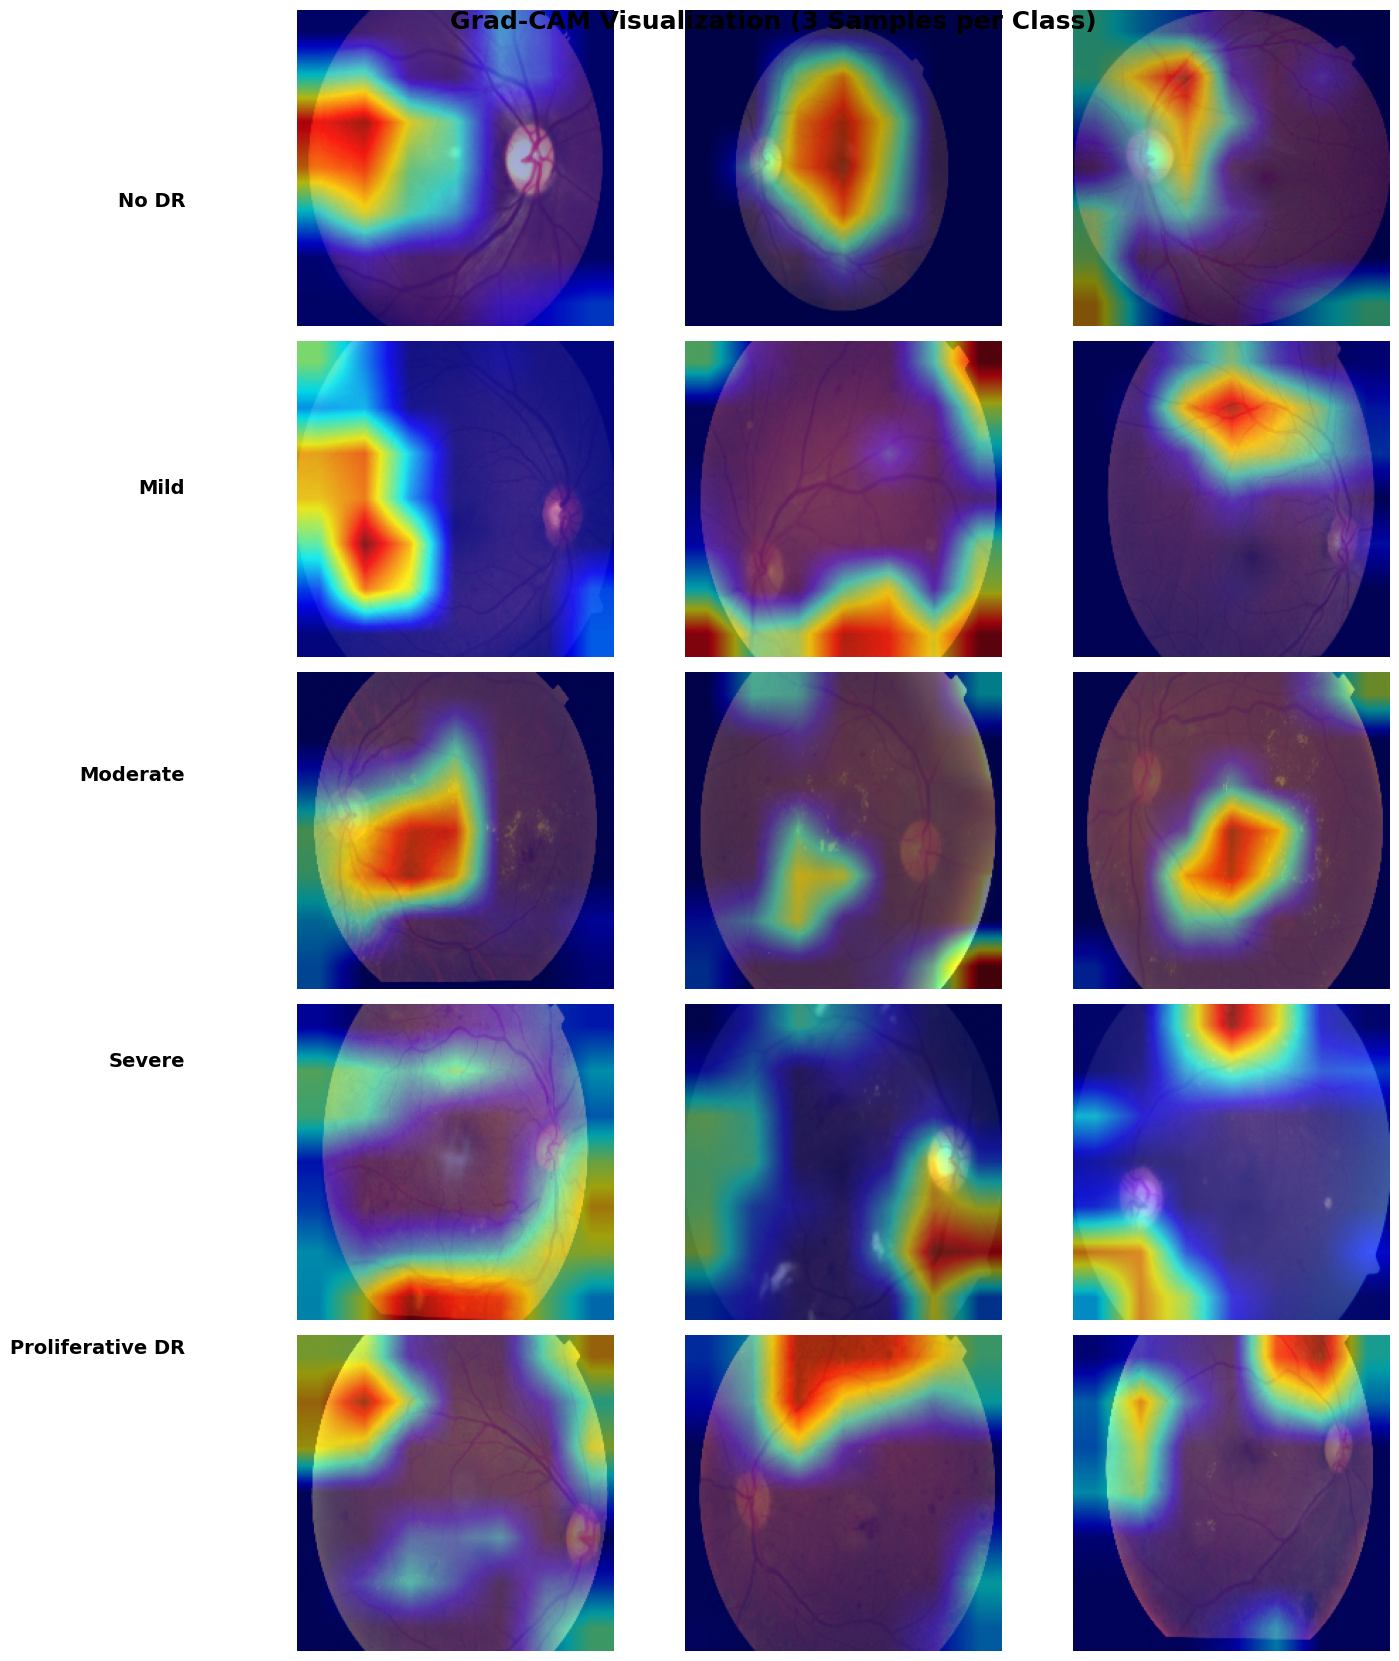

In [50]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict

# 📁 Path where Grad-CAM images are stored
gradcam_dir = "/kaggle/working/plots/gradcam"

# 📂 Get image files sorted
image_files = sorted([f for f in os.listdir(gradcam_dir) if f.endswith(".png")])

# 🧠 Expected format: "gradcam_classX_index.png"
# Group images by class
class_images = defaultdict(list)
for f in image_files:
    if "class" in f:
        cls = f.split("class")[1].split("_")[0]
        class_images[cls].append(f)

# 🔖 Mapping from class index → real name
class_map = {
    "0": "No DR",
    "1": "Mild",
    "2": "Moderate",
    "3": "Severe",
    "4": "Proliferative DR"
}

# 📊 Plotting in grid: 5 rows (one per class), 3 columns
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(14, 18))
fig.suptitle("Grad-CAM Visualization (3 Samples per Class)", fontsize=18, fontweight="bold", y=0.92)

for row, cls in enumerate(sorted(class_images.keys(), key=int)):
    for col in range(3):
        ax = axs[row, col]
        try:
            img_path = os.path.join(gradcam_dir, class_images[cls][col])
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis("off")
        except IndexError:
            ax.axis("off")

    # 🏷️ Add class name as row label on the left (outside plots)
    fig.text(
        0.08,                                    # x position (left side margin)
        (axs[row, 0].get_position().y0 + axs[row, 0].get_position().y1) / 2,  # center of row
        class_map.get(cls, f"Class {cls}"),
        ha="right", va="center",
        fontsize=14, fontweight="bold"
    )

plt.tight_layout(rect=[0.1, 0, 1, 0.95])  # leave space for row labels
plt.savefig("/kaggle/working/gradcam_classwise_grid.png", dpi=300, bbox_inches="tight")
plt.show()


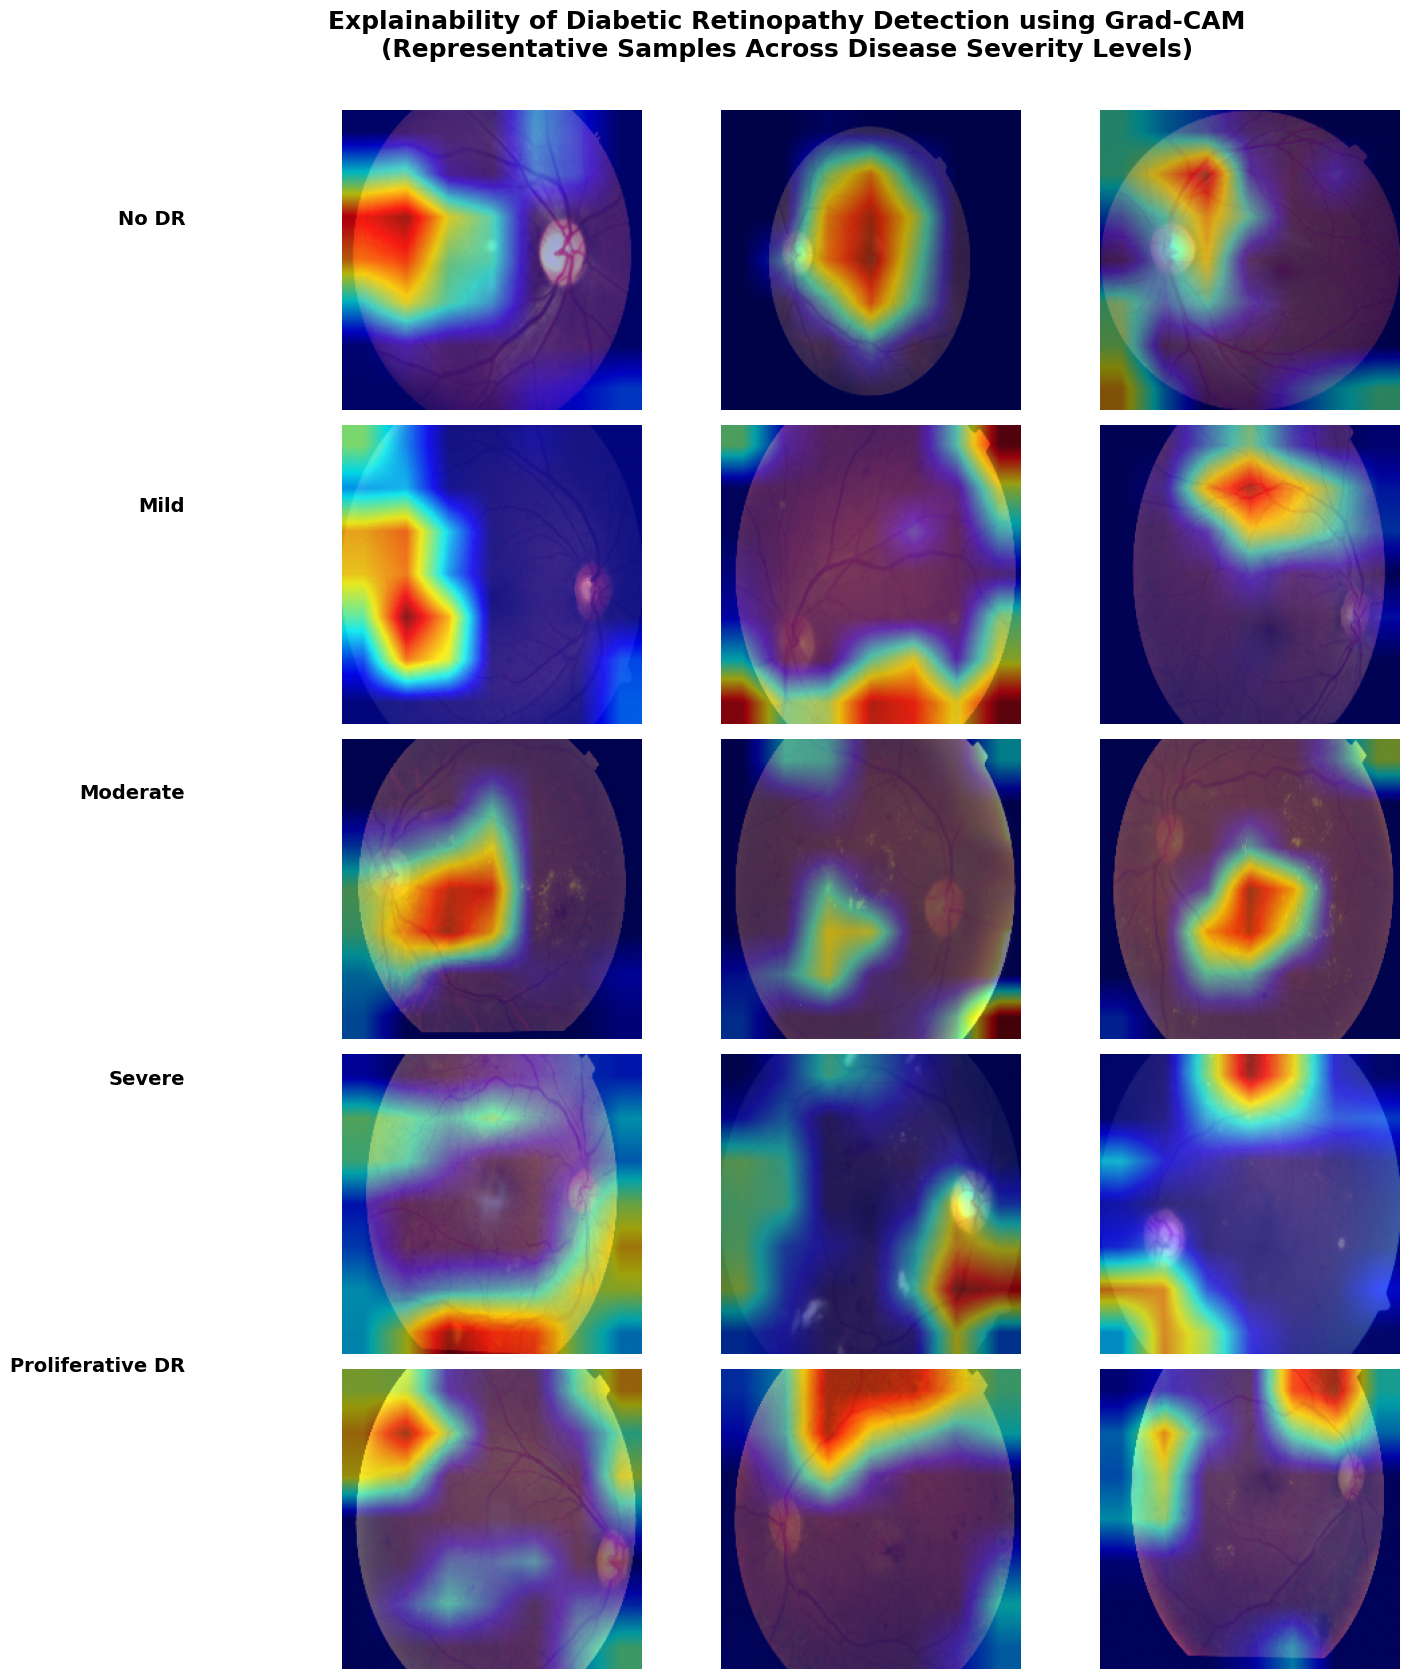

In [51]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict

# 📁 Path where Grad-CAM images are stored
gradcam_dir = "/kaggle/working/plots/gradcam"

# 📂 Get image files sorted
image_files = sorted([f for f in os.listdir(gradcam_dir) if f.endswith(".png")])

# 🧠 Expected format: "gradcam_classX_index.png"
# Group images by class
class_images = defaultdict(list)
for f in image_files:
    if "class" in f:
        cls = f.split("class")[1].split("_")[0]
        class_images[cls].append(f)

# 🔖 Mapping from class index → real name
class_map = {
    "0": "No DR",
    "1": "Mild",
    "2": "Moderate",
    "3": "Severe",
    "4": "Proliferative DR"
}

# 📊 Plotting in grid: 5 rows (one per class), 3 columns
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(14, 18))

# 🏷️ Research paper style title
fig.suptitle(
    "Explainability of Diabetic Retinopathy Detection using Grad-CAM\n"
    "(Representative Samples Across Disease Severity Levels)",
    fontsize=18, fontweight="bold", y=0.93
)

for row, cls in enumerate(sorted(class_images.keys(), key=int)):
    for col in range(3):
        ax = axs[row, col]
        try:
            img_path = os.path.join(gradcam_dir, class_images[cls][col])
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis("off")
        except IndexError:
            ax.axis("off")

    # 🏷️ Add class name as row label on the left (outside plots)
    fig.text(
        0.07,  # left margin for labels
        (axs[row, 0].get_position().y0 + axs[row, 0].get_position().y1) / 2,
        class_map.get(cls, f"Class {cls}"),
        ha="right", va="center",
        fontsize=14, fontweight="bold"
    )

plt.tight_layout(rect=[0.12, 0, 1, 0.92])  # leave space for labels + title
plt.savefig("/kaggle/working/gradcam_classwise_grid.png", dpi=400, bbox_inches="tight")
plt.show()


In [53]:
import torch
import pandas as pd
import os
from tqdm import tqdm

# ✅ Reload model architecture
model = XDRNet(num_classes=5)
model.load_state_dict(torch.load("/kaggle/working/models/xdrnet_best.pth", map_location=device))
model.to(device)
model.eval()

# ✅ Create folder to store predictions
os.makedirs("/kaggle/working/results", exist_ok=True)

# 🧠 Inference loop
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="🔍 Running Inference"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Save predictions
df_results = pd.DataFrame({"true": all_labels, "pred": all_preds})
df_results.to_csv("/kaggle/working/results/predictions.csv", index=False)
print("✅ Predictions saved to /kaggle/working/results/predictions.csv")


🔍 Running Inference: 100%|██████████| 57/57 [01:58<00:00,  2.08s/it]

✅ Predictions saved to /kaggle/working/results/predictions.csv


In [54]:
# Re-running the ROC-AUC generation after code execution state reset

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import os
import numpy as np

# Reload predictions
df = pd.read_csv("/kaggle/working/results/predictions.csv")

# Convert to one-hot for multi-class ROC
true_bin = label_binarize(df["true"], classes=[0, 1, 2, 3, 4])
pred_bin = label_binarize(df["pred"], classes=[0, 1, 2, 3, 4])
n_classes = true_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_bin[:, i], pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)

# Save figure
os.makedirs("/kaggle/working/results", exist_ok=True)
plt.savefig("/kaggle/working/results/multiclass_roc_auc.png")
plt.close()

"/kaggle/working/results/multiclass_roc_auc.png"


'/kaggle/working/results/multiclass_roc_auc.png'

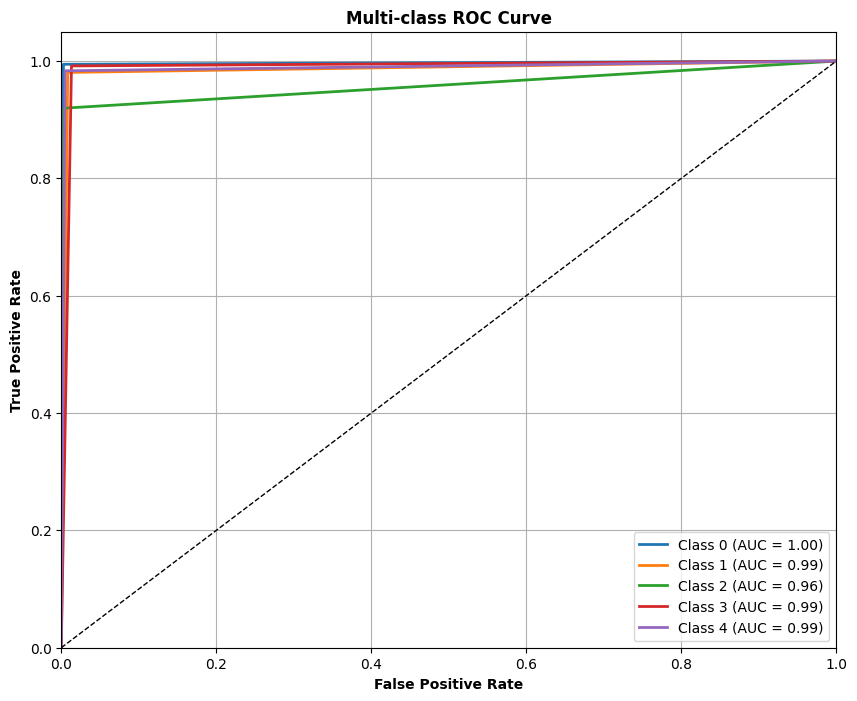

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import os

# Reload predictions
df = pd.read_csv("/kaggle/working/results/predictions.csv")

# Convert to one-hot for multi-class ROC
true_bin = label_binarize(df["true"], classes=[0, 1, 2, 3, 4])
pred_bin = label_binarize(df["pred"], classes=[0, 1, 2, 3, 4])
n_classes = true_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_bin[:, i], pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves with bold labels and title
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontweight="bold")
plt.ylabel("True Positive Rate", fontweight="bold")
plt.title("Multi-class ROC Curve", fontweight="bold")
plt.legend(loc="lower right")
plt.grid(True)

# Save figure
os.makedirs("/kaggle/working/results", exist_ok=True)
plt.savefig("/kaggle/working/results/multiclass_roc_auc.png")
plt.show()
